# Phase 2: Diffusion Transformer (DiT)

In Phase 1, we built an unconditional flow matching model using a **CNN (U-Net)**. It worked! We generated digits from noise. But the results were somewhat blurry, and the architecture has limitations.

In this notebook, we'll replace the CNN with a **Diffusion Transformer (DiT)** - the same architecture used in state-of-the-art models like Stable Diffusion 3 and Sora.

## Why Replace the CNN?

CNNs have been the workhorse of image generation for years. So why switch to transformers?

| Aspect | CNN (U-Net) | Transformer (DiT) |
|--------|-------------|-------------------|
| **Local vs Global** | Sees small local regions (3x3, 5x5 kernels) | Every patch can attend to every other patch |
| **Scaling** | Adding layers has diminishing returns | Scales predictably with more layers/parameters |
| **Architecture** | Complex skip connections, multiple resolutions | Simple: just stack identical blocks |
| **Conditioning** | Timestep added via bias terms | Timestep modulates entire layer (adaLN) |

The key insight from the [DiT paper](https://arxiv.org/abs/2212.09748): transformers follow **scaling laws** - double the compute, get predictably better results. This is why modern image generators use transformers.

## What We'll Learn

1. **Patchification**: How to convert an image into a sequence of patches (like words in a sentence)
2. **Positional Embeddings**: How the model knows where each patch is located spatially
3. **Adaptive Layer Norm (adaLN)**: How timestep information conditions every layer
4. **Self-Attention on Images**: How patches "talk" to each other to understand global structure

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Set up device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## 1. Patchification: Images as Sequences

Transformers were designed for **sequences** - lists of tokens like words in a sentence. But images are 2D grids of pixels. How do we bridge this gap?

The answer: **cut the image into patches** and treat each patch as a "token".

### How It Works

For our 28×28 MNIST images with patch size 4:

```
Original Image (28×28)          Patches (7×7 = 49 patches)
┌────────────────────┐          ┌──┬──┬──┬──┬──┬──┬──┐
│                    │          │ 1│ 2│ 3│ 4│ 5│ 6│ 7│
│                    │          ├──┼──┼──┼──┼──┼──┼──┤
│     (pixels)       │    →     │ 8│ 9│10│11│12│13│14│
│                    │          ├──┼──┼──┼──┼──┼──┼──┤
│                    │          │  │  │ ...49 total │
└────────────────────┘          └──┴──┴──┴──┴──┴──┴──┘
```

Each 4×4 patch contains 16 pixels. We then project these 16 values into a higher-dimensional "embedding" (e.g., 256 dimensions). This is similar to how word embeddings work in language models - a small input gets mapped to a rich representation.

### Why Patches?

- **Efficiency**: 784 pixels → 49 patches = 16× fewer tokens to process
- **Meaningful units**: A 4×4 patch captures local structure (edges, corners)
- **Scales well**: For larger images, just use larger patches or more patches

Let's visualize this:

In [17]:
# Load MNIST (same as Phase 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Get a sample image
sample_img, label = train_dataset[0]
print(f"Image shape: {sample_img.shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 5


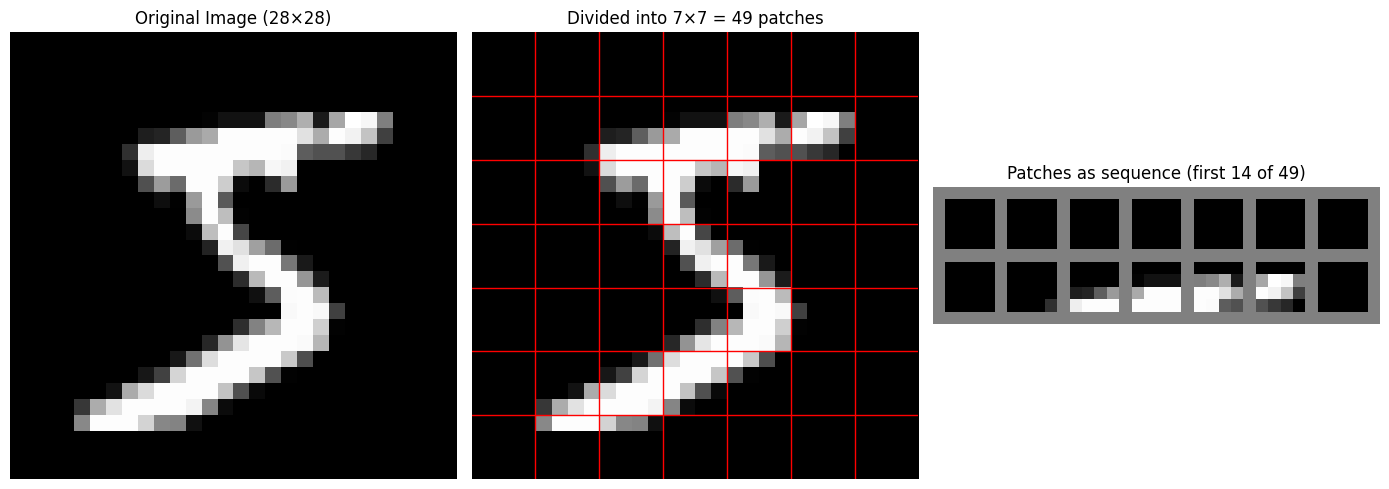


📊 Patchification Summary:
   • Original: 28×28 = 784 pixels
   • Patch size: 4×4 = 16 pixels per patch
   • Result: 49 patches
   • Each patch is embedded into a 256-dimensional vector
   • Sequence length for transformer: 49 tokens


In [18]:
def visualize_patchification(img, patch_size=4):
    """
    Show how an image gets divided into patches.
    """
    # Denormalize for display
    img_display = (img[0] + 1) / 2  # (H, W)
    
    H, W = img_display.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    
    # Original image
    axes[0].imshow(img_display.numpy(), cmap='gray')
    axes[0].set_title(f'Original Image ({H}×{W})', fontsize=12)
    axes[0].axis('off')
    
    # Image with patch grid overlay
    axes[1].imshow(img_display.numpy(), cmap='gray')
    # Draw grid lines
    for i in range(1, num_patches_h):
        axes[1].axhline(y=i * patch_size - 0.5, color='red', linewidth=1)
    for j in range(1, num_patches_w):
        axes[1].axvline(x=j * patch_size - 0.5, color='red', linewidth=1)
    axes[1].set_title(f'Divided into {num_patches_h}×{num_patches_w} = {num_patches_h * num_patches_w} patches', fontsize=12)
    axes[1].axis('off')
    
    # Show patches as a sequence
    patches = img_display.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
    patches = patches.reshape(-1, patch_size, patch_size)  # (49, 4, 4)
    
    # Create a grid showing first 14 patches (2 rows)
    patch_grid = torchvision.utils.make_grid(
        patches[:14].unsqueeze(1), nrow=7, padding=1, pad_value=0.5
    )
    axes[2].imshow(patch_grid[0].numpy(), cmap='gray')
    axes[2].set_title('Patches as sequence (first 14 of 49)', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Patchification Summary:")
    print(f"   • Original: {H}×{W} = {H*W} pixels")
    print(f"   • Patch size: {patch_size}×{patch_size} = {patch_size**2} pixels per patch")
    print(f"   • Result: {num_patches_h * num_patches_w} patches")
    print(f"   • Each patch is embedded into a {256}-dimensional vector")
    print(f"   • Sequence length for transformer: {num_patches_h * num_patches_w} tokens")

visualize_patchification(sample_img, patch_size=4)

## 2. Positional Embeddings: Where Is Each Patch?

When we flatten patches into a sequence, we lose spatial information. The transformer sees:

```
[patch_1, patch_2, patch_3, ..., patch_49]
```

But it doesn't know that patch_1 is in the top-left and patch_49 is in the bottom-right!

### The Solution: Positional Embeddings

We add a unique "position vector" to each patch embedding. This vector encodes the patch's (row, column) location.

```
patch_embedding + position_embedding = final_embedding
     (256-dim)       (256-dim)           (256-dim)
```

### How We Encode Position

We use **sinusoidal positional embeddings** - the same technique from the original "Attention Is All You Need" paper. The idea:

- Use sine and cosine functions at different frequencies
- Different positions create different patterns of highs and lows
- The model learns to decode these patterns to understand spatial relationships

For 2D images, we encode both row and column positions:

```
position_embedding = [sin/cos(row), sin/cos(column)]
                      └─ 128 dim ─┘  └── 128 dim ──┘
```

Let's visualize what these embeddings look like:

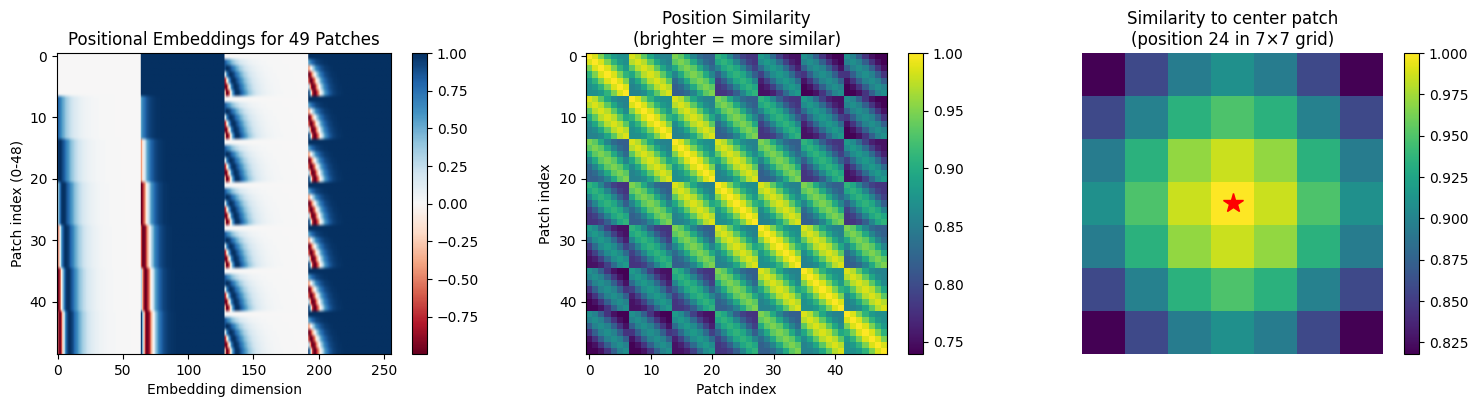


📊 Positional Embedding Insights:
   • Each patch gets a unique 256-dimensional position vector
   • Nearby patches have similar embeddings (see similarity matrix)
   • The center patch is most similar to its neighbors
   • This spatial structure helps the model understand image layout


In [19]:
def visualize_positional_embeddings(grid_size=7, embed_dim=256):
    """
    Visualize 2D sinusoidal positional embeddings.
    """
    import math
    
    half_dim = embed_dim // 4  # For sin_x, cos_x, sin_y, cos_y
    
    # Create frequency bands
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim) * -emb)
    
    # Create position indices
    pos = torch.arange(grid_size)
    
    # Compute embeddings
    pos_emb = pos[:, None] * emb[None, :]  # (grid_size, half_dim)
    sin_emb = torch.sin(pos_emb)
    cos_emb = torch.cos(pos_emb)
    pos_emb_1d = torch.cat([sin_emb, cos_emb], dim=-1)  # (grid_size, embed_dim//2)
    
    # Create 2D embeddings
    row_emb = pos_emb_1d.unsqueeze(1).expand(-1, grid_size, -1)
    col_emb = pos_emb_1d.unsqueeze(0).expand(grid_size, -1, -1)
    pos_2d = torch.cat([row_emb, col_emb], dim=-1)  # (7, 7, 256)
    pos_2d_flat = pos_2d.view(-1, embed_dim)  # (49, 256)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Show the full positional embedding matrix
    im = axes[0].imshow(pos_2d_flat.numpy(), aspect='auto', cmap='RdBu')
    axes[0].set_xlabel('Embedding dimension')
    axes[0].set_ylabel('Patch index (0-48)')
    axes[0].set_title('Positional Embeddings for 49 Patches')
    plt.colorbar(im, ax=axes[0])
    
    # Show similarity between positions (which patches are "close" in embedding space)
    similarity = torch.mm(pos_2d_flat, pos_2d_flat.T)
    similarity = similarity / similarity.max()  # Normalize
    im = axes[1].imshow(similarity.numpy(), cmap='viridis')
    axes[1].set_xlabel('Patch index')
    axes[1].set_ylabel('Patch index')
    axes[1].set_title('Position Similarity\n(brighter = more similar)')
    plt.colorbar(im, ax=axes[1])
    
    # Show what a specific patch's similarity looks like spatially
    center_patch = 24  # Center of 7x7 grid
    center_similarity = similarity[center_patch].view(grid_size, grid_size)
    im = axes[2].imshow(center_similarity.numpy(), cmap='viridis')
    axes[2].set_title(f'Similarity to center patch\n(position 24 in 7×7 grid)')
    # Mark the center
    axes[2].plot(3, 3, 'r*', markersize=15)
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Positional Embedding Insights:")
    print("   • Each patch gets a unique 256-dimensional position vector")
    print("   • Nearby patches have similar embeddings (see similarity matrix)")
    print("   • The center patch is most similar to its neighbors")
    print("   • This spatial structure helps the model understand image layout")

visualize_positional_embeddings()

## 3. Adaptive Layer Norm (adaLN): Timestep Conditioning

In Phase 1, we conditioned on timestep by **adding** the timestep embedding to feature maps. This works, but it's crude - like adjusting the volume on a stereo by adding a constant to all frequencies.

DiT uses a more sophisticated approach: **Adaptive Layer Normalization (adaLN)**.

### What is Layer Normalization?

Regular Layer Norm normalizes activations to have mean=0 and std=1, then applies learned scale (γ) and shift (β):

```
LayerNorm(x) = γ * (x - mean) / std + β
               ↑                       ↑
         learned scale           learned shift
```

### What Makes adaLN "Adaptive"?

Instead of using **fixed learned** γ and β, we **predict them from the timestep**:

```
timestep t → MLP → [scale, shift]
                      ↓      ↓
adaLN(x) = scale * LayerNorm(x) + shift
```

### Why This Matters

Different timesteps need different processing:

- **t ≈ 1.0 (mostly noise)**: Model should focus on finding large-scale structure
- **t ≈ 0.5 (half-way)**: Model should refine mid-level details
- **t ≈ 0.0 (almost clean)**: Model should add fine details

adaLN lets the model **dynamically adjust its behavior** at each timestep by modulating all the layer's activations.

Let's see how the scale/shift values change across timesteps:

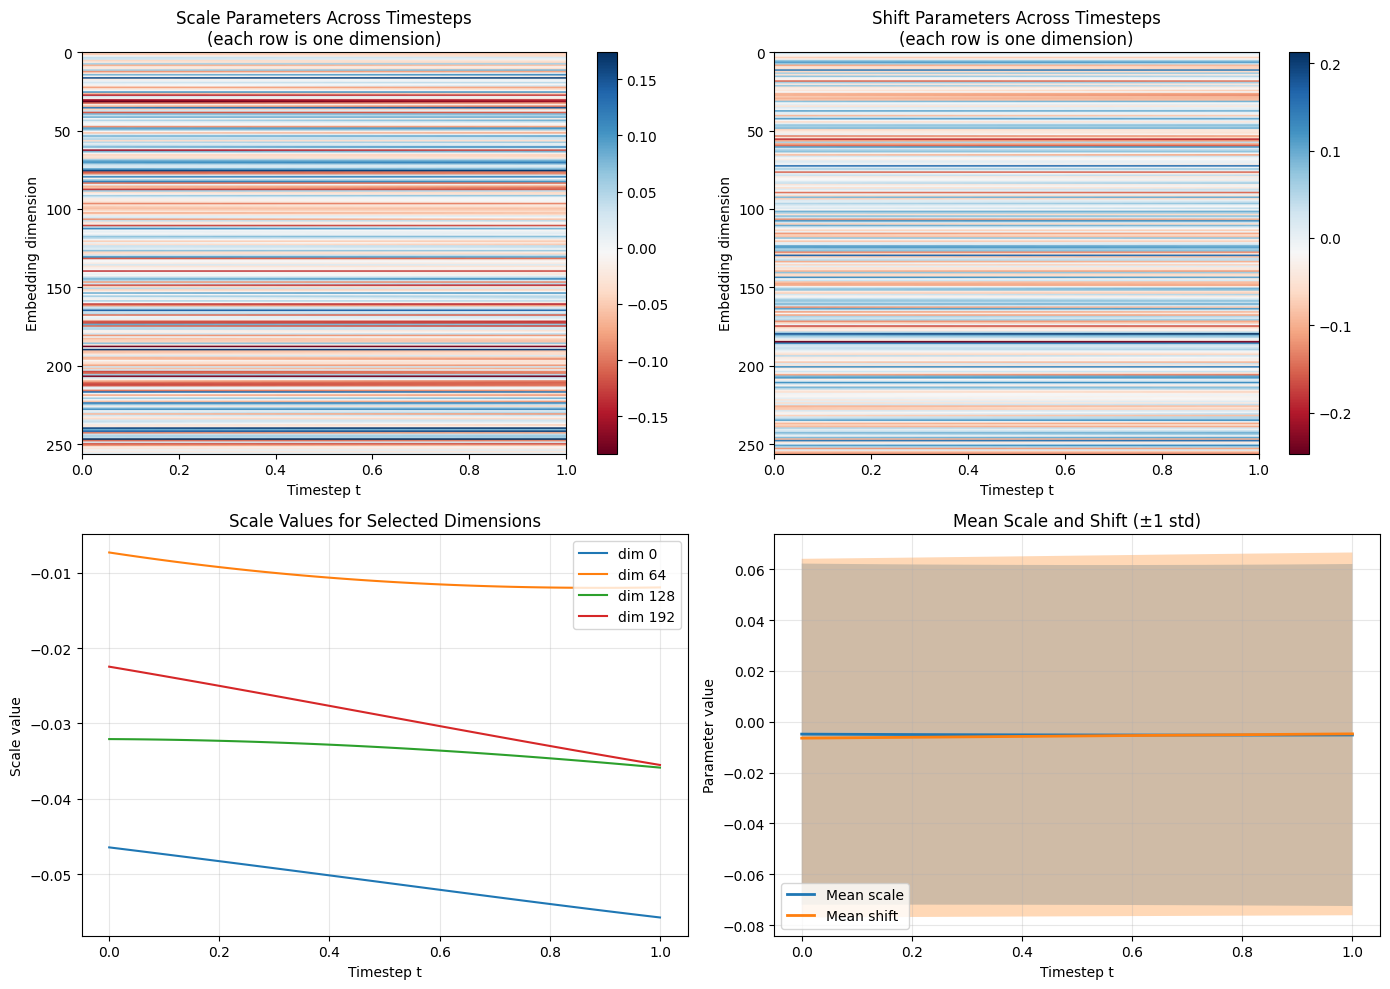


📊 adaLN Insights:
   • Each timestep produces different scale/shift parameters
   • The model learns to modulate activations based on noise level
   • This is much more expressive than just adding timestep embeddings
   • At t=0 vs t=1, the model behaves quite differently!


In [20]:
from opticus.dit import TimestepEmbedding, AdaLN

def visualize_adaln_modulation():
    """
    Show how adaLN parameters change across timesteps.
    """
    embed_dim = 256
    cond_dim = embed_dim * 4
    
    # Create modules
    time_embed = TimestepEmbedding(embed_dim, cond_dim)
    adaln = AdaLN(embed_dim, cond_dim)
    
    # Sample timesteps
    timesteps = torch.linspace(0, 1, 100)
    
    scales = []
    shifts = []
    
    with torch.no_grad():
        for t in timesteps:
            t_batch = t.unsqueeze(0)  # (1,)
            cond = time_embed(t_batch)  # (1, cond_dim)
            params = adaln.proj(cond)  # (1, embed_dim * 2)
            scale, shift = params.chunk(2, dim=-1)
            scales.append(scale.squeeze().numpy())
            shifts.append(shift.squeeze().numpy())
    
    scales = np.array(scales)  # (100, 256)
    shifts = np.array(shifts)  # (100, 256)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Heatmap of scale values across time and dimensions
    im = axes[0, 0].imshow(scales.T, aspect='auto', cmap='RdBu', 
                           extent=[0, 1, embed_dim, 0])
    axes[0, 0].set_xlabel('Timestep t')
    axes[0, 0].set_ylabel('Embedding dimension')
    axes[0, 0].set_title('Scale Parameters Across Timesteps\n(each row is one dimension)')
    plt.colorbar(im, ax=axes[0, 0])
    
    # Heatmap of shift values
    im = axes[0, 1].imshow(shifts.T, aspect='auto', cmap='RdBu',
                           extent=[0, 1, embed_dim, 0])
    axes[0, 1].set_xlabel('Timestep t')
    axes[0, 1].set_ylabel('Embedding dimension')
    axes[0, 1].set_title('Shift Parameters Across Timesteps\n(each row is one dimension)')
    plt.colorbar(im, ax=axes[0, 1])
    
    # Line plot of a few dimensions
    dims_to_plot = [0, 64, 128, 192]
    for d in dims_to_plot:
        axes[1, 0].plot(timesteps.numpy(), scales[:, d], label=f'dim {d}')
    axes[1, 0].set_xlabel('Timestep t')
    axes[1, 0].set_ylabel('Scale value')
    axes[1, 0].set_title('Scale Values for Selected Dimensions')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mean scale and shift across all dimensions
    axes[1, 1].plot(timesteps.numpy(), scales.mean(axis=1), label='Mean scale', linewidth=2)
    axes[1, 1].fill_between(timesteps.numpy(), 
                            scales.mean(axis=1) - scales.std(axis=1),
                            scales.mean(axis=1) + scales.std(axis=1),
                            alpha=0.3)
    axes[1, 1].plot(timesteps.numpy(), shifts.mean(axis=1), label='Mean shift', linewidth=2)
    axes[1, 1].fill_between(timesteps.numpy(),
                            shifts.mean(axis=1) - shifts.std(axis=1),
                            shifts.mean(axis=1) + shifts.std(axis=1),
                            alpha=0.3)
    axes[1, 1].set_xlabel('Timestep t')
    axes[1, 1].set_ylabel('Parameter value')
    axes[1, 1].set_title('Mean Scale and Shift (±1 std)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 adaLN Insights:")
    print("   • Each timestep produces different scale/shift parameters")
    print("   • The model learns to modulate activations based on noise level")
    print("   • This is much more expressive than just adding timestep embeddings")
    print("   • At t=0 vs t=1, the model behaves quite differently!")

visualize_adaln_modulation()

## 4. Self-Attention: How Patches Communicate

The core innovation of transformers is **self-attention**: each element in a sequence can "look at" every other element and decide what information to gather.

### For Images: Global Receptive Field

In a CNN, a pixel only "sees" its local neighborhood (e.g., 3×3). To see the whole image, you need many stacked layers.

In self-attention, **every patch can directly attend to every other patch**:

```
Patch in top-left corner can directly look at:
├── Adjacent patches (local context)
├── Center patches (what's the main subject?)
└── Bottom-right patches (what's the background?)
```

### How Attention Works

For each patch, we compute:

1. **Query (Q)**: "What am I looking for?"
2. **Key (K)**: "What do I contain?"
3. **Value (V)**: "What information can I share?"

Then:
```
Attention(Q, K, V) = softmax(Q × K^T / √d) × V
                          ↑
              "attention scores" - how much each patch
              should contribute to this patch's output
```

### What Does the Model Actually Attend To?

After training, we can visualize attention patterns to see what relationships the model learns. Typically:
- Early layers: Local patterns (edges, textures)
- Middle layers: Object parts (strokes, curves)
- Late layers: Global structure (digit identity)

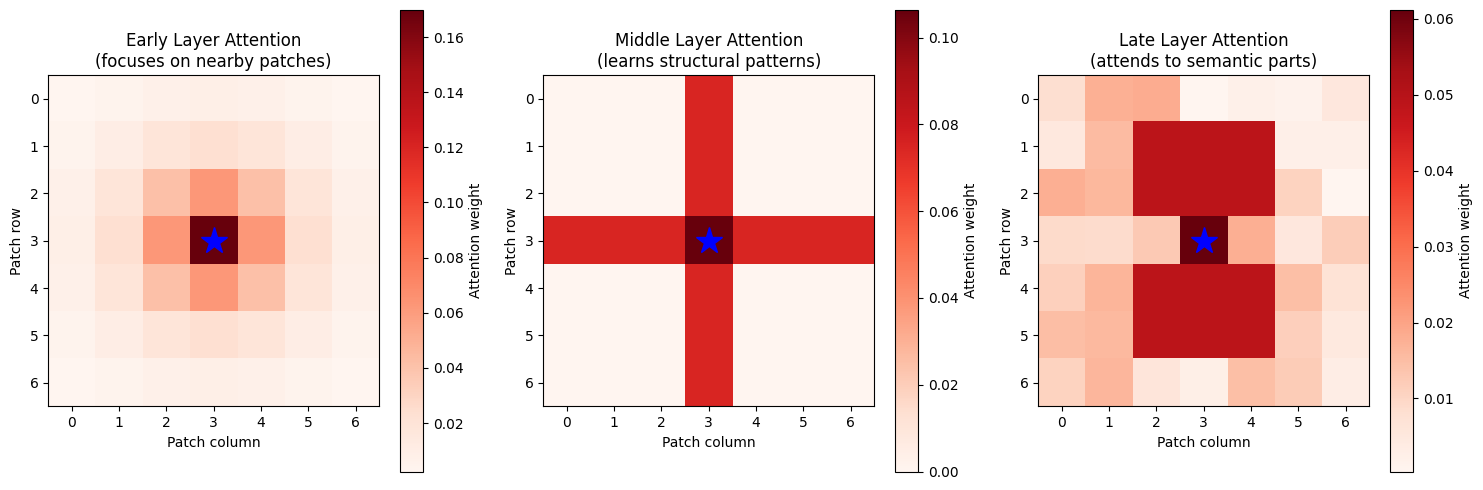


📊 Self-Attention Insights:
   • The blue star (★) is the 'query' patch asking 'what should I look at?'
   • Brighter red = higher attention weight = more information gathered
   • Early layers: Focus locally (like CNN kernels)
   • Middle layers: Learn structural relationships
   • Late layers: Attend to semantically relevant regions
   • This global view is why transformers excel at understanding structure


In [21]:
def visualize_attention_concept():
    """
    Illustrate how self-attention works on image patches.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Create a simple 7x7 grid representing our 49 patches
    grid = np.zeros((7, 7))
    
    # Highlight center patch (query)
    query_pos = (3, 3)  # Center
    
    # Simulate attention pattern 1: Local attention (like early layers)
    local_attention = np.zeros((7, 7))
    for i in range(7):
        for j in range(7):
            dist = np.sqrt((i - query_pos[0])**2 + (j - query_pos[1])**2)
            local_attention[i, j] = np.exp(-dist)  # Gaussian falloff
    local_attention /= local_attention.sum()
    
    im = axes[0].imshow(local_attention, cmap='Reds')
    axes[0].plot(query_pos[1], query_pos[0], 'b*', markersize=20)
    axes[0].set_title('Early Layer Attention\n(focuses on nearby patches)', fontsize=12)
    axes[0].set_xlabel('Patch column')
    axes[0].set_ylabel('Patch row')
    plt.colorbar(im, ax=axes[0], label='Attention weight')
    
    # Simulate attention pattern 2: Stripe pattern (like middle layers learning structure)
    stripe_attention = np.zeros((7, 7))
    stripe_attention[3, :] = 0.7  # Horizontal stripe
    stripe_attention[:, 3] = 0.7  # Vertical stripe  
    stripe_attention[3, 3] = 1.0  # Center
    stripe_attention /= stripe_attention.sum()
    
    im = axes[1].imshow(stripe_attention, cmap='Reds')
    axes[1].plot(query_pos[1], query_pos[0], 'b*', markersize=20)
    axes[1].set_title('Middle Layer Attention\n(learns structural patterns)', fontsize=12)
    axes[1].set_xlabel('Patch column')
    axes[1].set_ylabel('Patch row')
    plt.colorbar(im, ax=axes[1], label='Attention weight')
    
    # Simulate attention pattern 3: Global/semantic (like late layers)
    global_attention = np.random.rand(7, 7) * 0.3
    # Strong attention to specific "semantic" regions
    global_attention[1:3, 2:5] = 0.8  # Top region
    global_attention[4:6, 2:5] = 0.8  # Bottom region
    global_attention[3, 3] = 1.0
    global_attention /= global_attention.sum()
    
    im = axes[2].imshow(global_attention, cmap='Reds')
    axes[2].plot(query_pos[1], query_pos[0], 'b*', markersize=20)
    axes[2].set_title('Late Layer Attention\n(attends to semantic parts)', fontsize=12)
    axes[2].set_xlabel('Patch column')
    axes[2].set_ylabel('Patch row')
    plt.colorbar(im, ax=axes[2], label='Attention weight')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Self-Attention Insights:")
    print("   • The blue star (★) is the 'query' patch asking 'what should I look at?'")
    print("   • Brighter red = higher attention weight = more information gathered")
    print("   • Early layers: Focus locally (like CNN kernels)")
    print("   • Middle layers: Learn structural relationships")
    print("   • Late layers: Attend to semantically relevant regions")
    print("   • This global view is why transformers excel at understanding structure")

visualize_attention_concept()

## 5. The Complete DiT Architecture

Now let's put it all together. Here's the full DiT architecture:

```
Input Image (1, 28, 28)
         │
         ▼
┌─────────────────┐
│  Patch Embed    │  Split into 4×4 patches, project to 256-dim
│  (49 patches)   │
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│  + Positional   │  Add 2D sinusoidal position embeddings
│    Embeddings   │
└────────┬────────┘
         │
         │         ┌─────────────────┐
         │         │ Timestep t      │
         │         │      │          │
         │         │      ▼          │
         │         │ Sinusoidal Emb  │
         │         │      │          │
         │         │      ▼          │
         │         │    MLP          │
         │         │      │          │
         │         │      ▼          │
         │         │ Conditioning    │──────┐
         │         └─────────────────┘      │
         │                                  │
         ▼                                  │
┌─────────────────────────────────────┐     │
│         DiT Block (×6)              │◄────┘
│  ┌───────────────────────────────┐  │
│  │ adaLN(x, cond)                │  │  Adaptive norm with timestep
│  │      │                        │  │
│  │      ▼                        │  │
│  │ Self-Attention                │  │  Patches attend to each other
│  │      │                        │  │
│  │      + (residual)             │  │
│  │      │                        │  │
│  │ adaLN(x, cond)                │  │
│  │      │                        │  │
│  │      ▼                        │  │
│  │    MLP                        │  │  Per-patch transformation
│  │      │                        │  │
│  │      + (residual)             │  │
│  └───────────────────────────────┘  │
└────────────────┬────────────────────┘
                 │
                 ▼
┌─────────────────┐
│  Layer Norm     │
│       │         │
│       ▼         │
│  Linear Proj    │  Project 256-dim back to patch pixels (16)
│       │         │
│       ▼         │
│   Unpatchify    │  Reassemble patches into image
└────────┬────────┘
         │
         ▼
Output Velocity (1, 28, 28)
```

Let's create the model and examine its components:

In [22]:
from opticus.dit import DiT

# Create DiT model
model = DiT(
    img_size=28,       # MNIST image size
    patch_size=4,      # 4×4 patches → 7×7 = 49 patches
    in_channels=1,     # Grayscale
    embed_dim=256,     # Embedding dimension
    depth=6,           # Number of transformer blocks
    num_heads=8,       # Attention heads (256 / 8 = 32 dim per head)
    mlp_ratio=4.0,     # MLP hidden dim = 256 * 4 = 1024
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"DiT Parameters: {num_params:,}")
print(f"\nCompare to Phase 1 CNN: ~1.8M parameters")
print(f"DiT has {'more' if num_params > 1_800_000 else 'fewer'} parameters")

# Test forward pass
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)

with torch.no_grad():
    test_out = model(test_x, test_t)

print(f"\nInput shape:  {test_x.shape}")
print(f"Output shape: {test_out.shape}")
print("✓ Forward pass successful!")

DiT Parameters: 12,351,760

Compare to Phase 1 CNN: ~1.8M parameters
DiT has more parameters

Input shape:  torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 1, 28, 28])
✓ Forward pass successful!


In [23]:
# Let's trace through the model step by step
print("=" * 60)
print("TRACING THROUGH DiT ARCHITECTURE")
print("=" * 60)

x = torch.randn(1, 1, 28, 28, device=device)  # Single image
t = torch.tensor([0.5], device=device)  # Timestep

print(f"\n1. INPUT")
print(f"   Image shape: {x.shape}")
print(f"   Timestep: {t.item():.1f}")

# Step 1: Patch embedding
with torch.no_grad():
    patches = model.patch_embed(x)
print(f"\n2. PATCH EMBEDDING")
print(f"   Input:  (1, 1, 28, 28) - one grayscale image")
print(f"   Output: {patches.shape} - {patches.shape[1]} patches, each {patches.shape[2]}-dimensional")

# Step 2: Add positional embeddings
with torch.no_grad():
    patches_pos = model.pos_embed(patches)
print(f"\n3. POSITIONAL EMBEDDINGS")
print(f"   Added position info to each patch")
print(f"   Shape unchanged: {patches_pos.shape}")

# Step 3: Timestep embedding
with torch.no_grad():
    cond = model.time_embed(t)
print(f"\n4. TIMESTEP EMBEDDING")
print(f"   Input:  t = {t.item():.1f}")
print(f"   Output: {cond.shape} - conditioning vector for adaLN")

# Step 4: Transformer blocks
print(f"\n5. TRANSFORMER BLOCKS (×{len(model.blocks)})")
print(f"   Each block: adaLN → Self-Attention → adaLN → MLP")
print(f"   Timestep conditioning via adaLN at each block")

# Step 5: Final layers
print(f"\n6. OUTPUT PROJECTION")
print(f"   Final LayerNorm + Linear: {patches.shape} → (1, 49, 16)")
print(f"   Unpatchify: (1, 49, 16) → (1, 1, 28, 28)")

with torch.no_grad():
    output = model(x, t)
print(f"\n7. FINAL OUTPUT")
print(f"   Velocity field shape: {output.shape}")
print(f"   Same as input - predicts velocity at each pixel")

TRACING THROUGH DiT ARCHITECTURE

1. INPUT
   Image shape: torch.Size([1, 1, 28, 28])
   Timestep: 0.5

2. PATCH EMBEDDING
   Input:  (1, 1, 28, 28) - one grayscale image
   Output: torch.Size([1, 49, 256]) - 49 patches, each 256-dimensional

3. POSITIONAL EMBEDDINGS
   Added position info to each patch
   Shape unchanged: torch.Size([1, 49, 256])

4. TIMESTEP EMBEDDING
   Input:  t = 0.5
   Output: torch.Size([1, 1024]) - conditioning vector for adaLN

5. TRANSFORMER BLOCKS (×6)
   Each block: adaLN → Self-Attention → adaLN → MLP
   Timestep conditioning via adaLN at each block

6. OUTPUT PROJECTION
   Final LayerNorm + Linear: torch.Size([1, 49, 256]) → (1, 49, 16)
   Unpatchify: (1, 49, 16) → (1, 1, 28, 28)

7. FINAL OUTPUT
   Velocity field shape: torch.Size([1, 1, 28, 28])
   Same as input - predicts velocity at each pixel


## 6. Training the DiT

The training process is **exactly the same** as Phase 1! The only change is the model architecture.

This is the beauty of flow matching - the training objective is model-agnostic:

```python
# Same training loop, different model
loss = MSE(model(x_t, t), velocity_target)
```

We'll train for 30 epochs to see results quickly, but you can increase this for better quality.

In [24]:
from opticus.train import Trainer

# Create data loader
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

# Create trainer (same as Phase 1, just with DiT model)
trainer = Trainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    device=device,
)

print("Training DiT...")
print("(This may take longer than the CNN due to attention computation)")
print()

NUM_EPOCHS = 30  # Increase to 20-30 for better results
losses = trainer.train(num_epochs=NUM_EPOCHS)

Training DiT...
(This may take longer than the CNN due to attention computation)

Training on cuda
Model parameters: 12,351,760


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.01it/s, loss=0.3809]


Epoch 1: avg_loss = 0.8381


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.97it/s, loss=0.3122]


Epoch 2: avg_loss = 0.3408


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.90it/s, loss=0.3052]


Epoch 3: avg_loss = 0.3042


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.90it/s, loss=0.2777]


Epoch 4: avg_loss = 0.2924


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.86it/s, loss=0.2706]


Epoch 5: avg_loss = 0.2854


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.85it/s, loss=0.2750]


Epoch 6: avg_loss = 0.2804


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.82it/s, loss=0.2804]


Epoch 7: avg_loss = 0.2759


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.80it/s, loss=0.2788]


Epoch 8: avg_loss = 0.2712


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.84it/s, loss=0.2588]


Epoch 9: avg_loss = 0.2655


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.83it/s, loss=0.2438]


Epoch 10: avg_loss = 0.2492


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.80it/s, loss=0.2246]


Epoch 11: avg_loss = 0.2339


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.80it/s, loss=0.2107]


Epoch 12: avg_loss = 0.2268


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.70it/s, loss=0.2088]


Epoch 13: avg_loss = 0.2213


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.67it/s, loss=0.2123]


Epoch 14: avg_loss = 0.2176


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.63it/s, loss=0.2157]


Epoch 15: avg_loss = 0.2145


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.73it/s, loss=0.2185]


Epoch 16: avg_loss = 0.2120


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.78it/s, loss=0.2075]


Epoch 17: avg_loss = 0.2099


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.71it/s, loss=0.1916]


Epoch 18: avg_loss = 0.2077


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.73it/s, loss=0.1783]


Epoch 19: avg_loss = 0.2062


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.73it/s, loss=0.2006]


Epoch 20: avg_loss = 0.2041


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.75it/s, loss=0.1989]


Epoch 21: avg_loss = 0.2039


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.70it/s, loss=0.2021]


Epoch 22: avg_loss = 0.2024


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.76it/s, loss=0.2015]


Epoch 23: avg_loss = 0.2010


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.76it/s, loss=0.2052]


Epoch 24: avg_loss = 0.2001


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.76it/s, loss=0.1914]


Epoch 25: avg_loss = 0.1992


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.69it/s, loss=0.2095]


Epoch 26: avg_loss = 0.1987


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.69it/s, loss=0.2115]


Epoch 27: avg_loss = 0.1975


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.71it/s, loss=0.2013]


Epoch 28: avg_loss = 0.1969


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.71it/s, loss=0.2033]


Epoch 29: avg_loss = 0.1954


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.71it/s, loss=0.1954]

Epoch 30: avg_loss = 0.1946


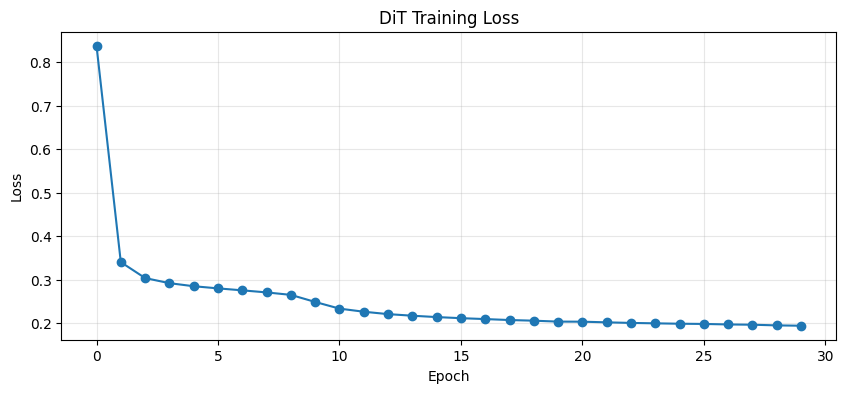


Final loss: 0.1946


In [25]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DiT Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal loss: {losses[-1]:.4f}")

## 7. Generate Samples with DiT

Now let's generate some digits! The sampling process is identical to Phase 1:

1. Start from pure noise (t=1)
2. Use model to predict velocity
3. Take a step toward data (t→0)
4. Repeat until t=0

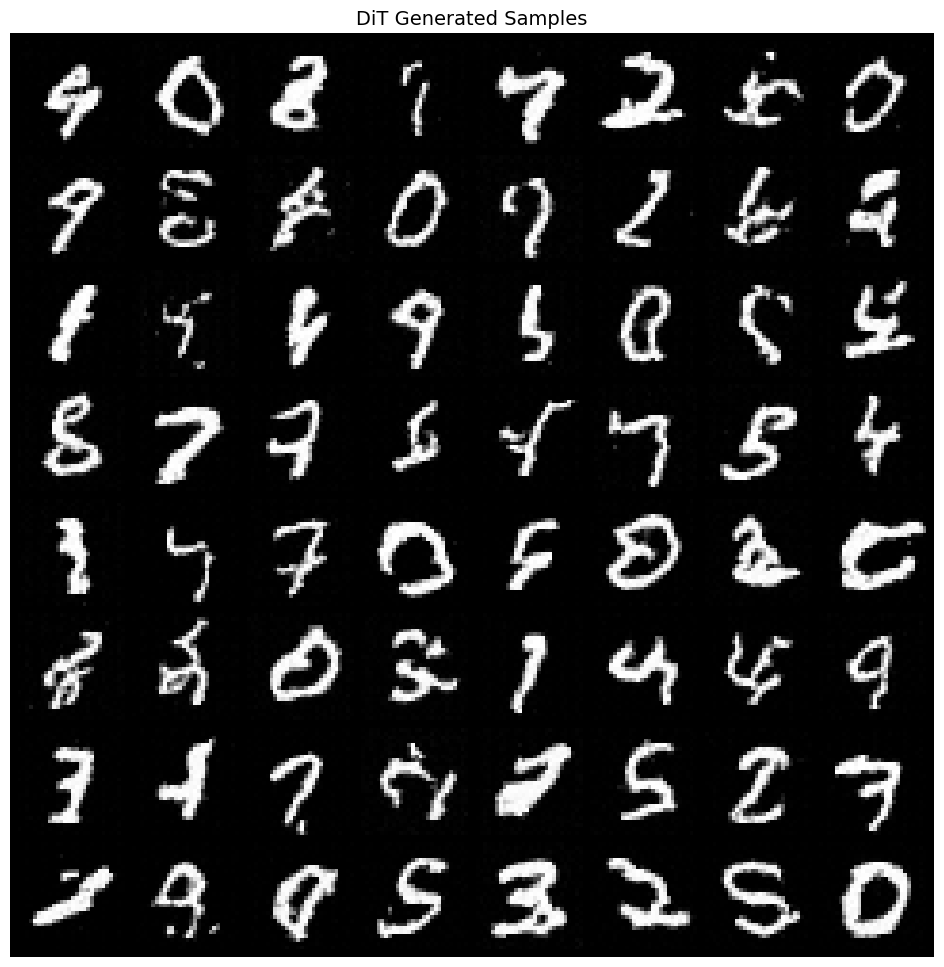

In [26]:
from opticus.sampling import sample

def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    images = (images + 1) / 2  # Denormalize
    images = images.clamp(0, 1)
    
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# Generate samples
model.eval()
with torch.no_grad():
    generated, trajectory = sample(
        model=model,
        num_samples=64,
        image_shape=(1, 28, 28),
        num_steps=50,
        device=device,
        return_trajectory=True,
    )

show_images(generated, nrow=8, title="DiT Generated Samples")

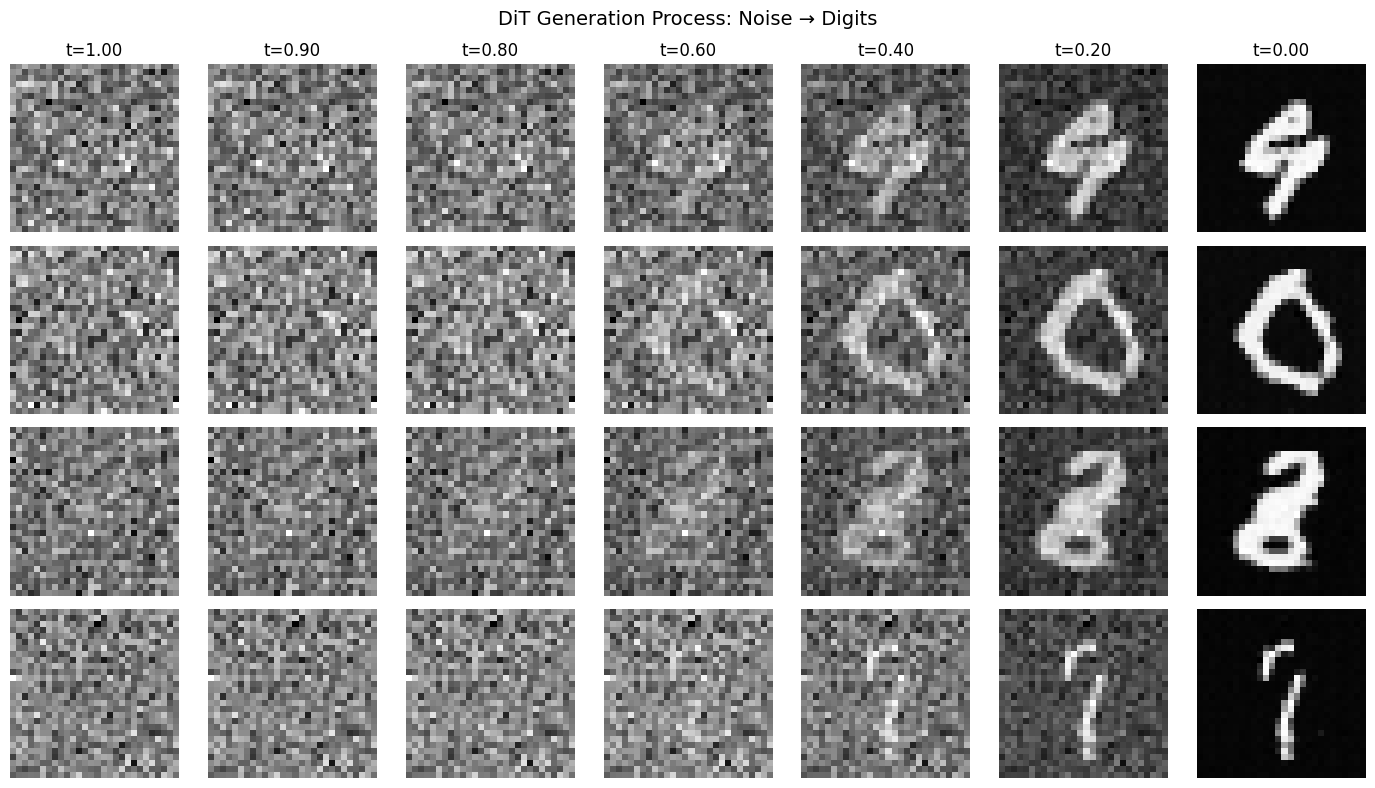

In [27]:
# Visualize the generation process
num_to_show = 4
steps_to_show = [0, 5, 10, 20, 30, 40, 50]

fig, axes = plt.subplots(num_to_show, len(steps_to_show), figsize=(14, 8))

for row in range(num_to_show):
    for col, step_idx in enumerate(steps_to_show):
        img = trajectory[step_idx][row, 0]
        img = (img + 1) / 2  # Denormalize
        axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            t_val = 1.0 - step_idx / 50
            axes[row, col].set_title(f't={t_val:.2f}')

plt.suptitle('DiT Generation Process: Noise → Digits', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Compare: CNN vs DiT vs Real

Now for the moment of truth - let's compare our DiT against:
1. **Phase 1 CNN (U-Net)**: The simple convolutional model we built first
2. **Real MNIST**: Ground truth digits to evaluate quality

This comparison will help us understand what the transformer architecture brings to the table.

**What to look for:**
- **Sharpness**: Are DiT edges cleaner than CNN edges?
- **Consistency**: Which model produces more realistic-looking digits?
- **Diversity**: Do both models generate all digit classes?
- **Artifacts**: Which model has fewer blobs or strange patterns?

First, we need to train a CNN model (or load a saved checkpoint if you have one):

In [30]:
import os
from opticus.models import SimpleUNet

# Try to load a saved CNN checkpoint, otherwise train a fresh one
cnn_checkpoint_path = "phase1_model.pt"

cnn_model = SimpleUNet(
    in_channels=1,
    model_channels=64,
    time_emb_dim=128,
).to(device)

if os.path.exists(cnn_checkpoint_path):
    print(f"Loading CNN from {cnn_checkpoint_path}...")
    checkpoint = torch.load(cnn_checkpoint_path, map_location=device)
    cnn_model.load_state_dict(checkpoint["model_state_dict"])
    print("CNN loaded successfully!")
else:
    print("No saved CNN checkpoint found. Training a fresh CNN for comparison...")
    print("(This will take a few minutes)\n")
    
    cnn_trainer = Trainer(
        model=cnn_model,
        dataloader=train_loader,
        lr=1e-4,
        weight_decay=0.01,
        device=device,
    )
    
    # Train for same number of epochs as DiT for fair comparison
    cnn_losses = cnn_trainer.train(num_epochs=NUM_EPOCHS)
    print(f"\nCNN training complete! Final loss: {cnn_losses[-1]:.4f}")

Loading CNN from phase1_model.pt...
CNN loaded successfully!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029076517..1.0254933].                              
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.095811844..1.0676966].


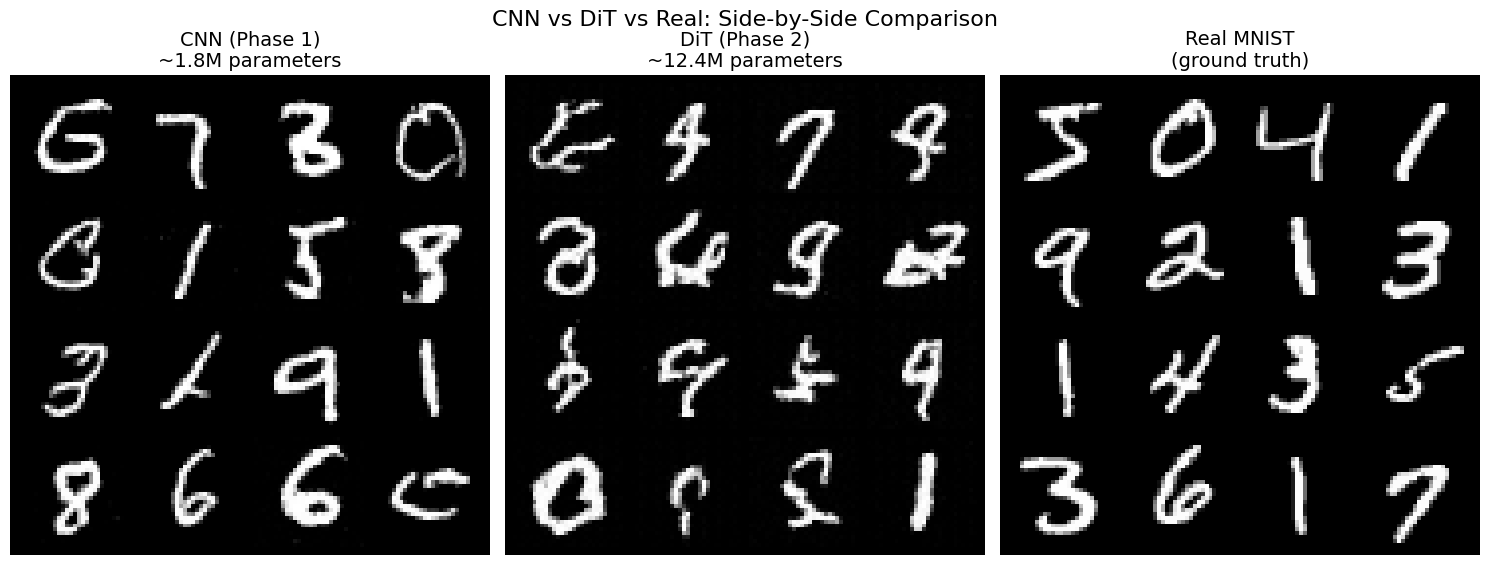

In [31]:
# Now generate samples from all three sources and compare

# 1. Generate from DiT (already trained above)
model.eval()
with torch.no_grad():
    dit_samples = sample(
        model=model,
        num_samples=16,
        image_shape=(1, 28, 28),
        num_steps=50,
        device=device,
    )

# 2. Generate from CNN
cnn_model.eval()
with torch.no_grad():
    cnn_samples = sample(
        model=cnn_model,
        num_samples=16,
        image_shape=(1, 28, 28),
        num_steps=50,
        device=device,
    )

# 3. Get real MNIST samples
real_samples = torch.stack([train_dataset[i][0] for i in range(16)])

# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# CNN samples
cnn_grid = torchvision.utils.make_grid((cnn_samples + 1) / 2, nrow=4, padding=2)
axes[0].imshow(cnn_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[0].set_title('CNN (Phase 1)\n~1.8M parameters', fontsize=14)
axes[0].axis('off')

# DiT samples
dit_grid = torchvision.utils.make_grid((dit_samples + 1) / 2, nrow=4, padding=2)
axes[1].imshow(dit_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[1].set_title('DiT (Phase 2)\n~12.4M parameters', fontsize=14)
axes[1].axis('off')

# Real samples
real_grid = torchvision.utils.make_grid((real_samples + 1) / 2, nrow=4, padding=2)
axes[2].imshow(real_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[2].set_title('Real MNIST\n(ground truth)', fontsize=14)
axes[2].axis('off')

plt.suptitle('CNN vs DiT vs Real: Side-by-Side Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [32]:
print("📊 Comparison Analysis:")
print()
print("ARCHITECTURE DIFFERENCES:")
print(f"   • CNN (U-Net):  ~1.8M parameters, local receptive field (3×3 kernels)")
print(f"   • DiT:          ~12.4M parameters, global receptive field (self-attention)")
print()
print("WHAT TO OBSERVE:")
print("   • Edge sharpness: Are digit boundaries cleaner in one model?")
print("   • Stroke consistency: Do strokes have natural thickness variation?")
print("   • Global coherence: Do digits look like complete, coherent shapes?")
print("   • Failure modes: What do 'bad' samples look like for each model?")
print()
print("WHY DiT MIGHT PERFORM DIFFERENTLY:")
print("   • Self-attention lets distant patches coordinate (e.g., top and bottom of an '8')")
print("   • adaLN provides stronger timestep conditioning than additive injection")
print("   • More parameters = more capacity to learn complex patterns")
print("   • But also: more parameters = needs more data/training to converge")

📊 Comparison Analysis:

ARCHITECTURE DIFFERENCES:
   • CNN (U-Net):  ~1.8M parameters, local receptive field (3×3 kernels)
   • DiT:          ~12.4M parameters, global receptive field (self-attention)

WHAT TO OBSERVE:
   • Edge sharpness: Are digit boundaries cleaner in one model?
   • Stroke consistency: Do strokes have natural thickness variation?
   • Global coherence: Do digits look like complete, coherent shapes?
   • Failure modes: What do 'bad' samples look like for each model?

WHY DiT MIGHT PERFORM DIFFERENTLY:
   • Self-attention lets distant patches coordinate (e.g., top and bottom of an '8')
   • adaLN provides stronger timestep conditioning than additive injection
   • More parameters = more capacity to learn complex patterns
   • But also: more parameters = needs more data/training to converge


## Key Takeaways

### What We Built

We replaced the Phase 1 CNN with a **Diffusion Transformer (DiT)** that:

1. **Patchifies** images into sequences (like words in a sentence)
2. **Adds positional embeddings** so the model knows where each patch is
3. **Uses self-attention** to let every patch communicate with every other patch
4. **Conditions on timestep via adaLN** - modulating layer behavior based on noise level

### Why DiT Matters

| Property | Why It's Important |
|----------|-------------------|
| **Global attention** | Each patch sees the whole image, not just neighbors |
| **Scalable** | More layers/parameters = better results (predictably) |
| **Simple architecture** | Just stack identical blocks - easy to scale up |
| **Strong conditioning** | adaLN deeply integrates timestep information |

### The Same Training Works!

The flow matching loss is **model-agnostic**. We can swap CNN for Transformer (or any architecture) without changing the training objective:

```python
loss = MSE(model(x_t, t), velocity)
```

## Next Steps (Phase 3)

In Phase 3, we'll add **class conditioning** to control which digit we generate:

- Add class embedding to the conditioning
- Implement **Classifier-Free Guidance (CFG)** for stronger conditioning
- "Generate a 7" → model produces a 7!

This is the stepping stone to text conditioning ("a photo of a cat" → cat image).

In [29]:
# Optionally save the trained model
# trainer.save_checkpoint("phase2_dit.pt")